In [5]:
import tensorflow as tf
from tensorflow import keras

In [6]:
import pandas as pd
import os

In [14]:
# https://www.kaggle.com/datasets/mostafaabla/garbage-classification
root='/kaggle/input/d/mostafaabla/garbage-classification/garbage_classification/'
data={}
for i in os.listdir(root):
    print(i)
    for j in os.walk(root+i):
        for k in j[2]:
            data[root+i+'/'+k]=i

metal
white-glass
biological
paper
brown-glass
battery
trash
cardboard
shoes
clothes
plastic
green-glass


In [15]:
data=pd.DataFrame(data.items(),columns=['path','label'])
data=data.sample(frac=1)
data

,path,label
6110,/kaggle/input/d/mostafaabla/garbage-classifica...,cardboard
963,/kaggle/input/d/mostafaabla/garbage-classifica...,white-glass
7904,/kaggle/input/d/mostafaabla/garbage-classifica...,shoes
12936,/kaggle/input/d/mostafaabla/garbage-classifica...,clothes
4577,/kaggle/input/d/mostafaabla/garbage-classifica...,battery
...,...,...
1509,/kaggle/input/d/mostafaabla/garbage-classifica...,white-glass
7052,/kaggle/input/d/mostafaabla/garbage-classifica...,shoes
8499,/kaggle/input/d/mostafaabla/garbage-classifica...,shoes
8975,/kaggle/input/d/mostafaabla/garbage-classifica...,clothes


In [16]:
data["label"].value_counts()

clothes        5325
shoes          1977
paper          1050
biological      985
battery         945
cardboard       891
plastic         865
white-glass     775
metal           769
trash           697
green-glass     629
brown-glass     607
Name: label, dtype: int64

In [17]:
#Setting the number of files we want in each class. This is the number of brown_glass images in this case since that is the class with the least number of images. 
file_count = 607
#Create samples list for putting the number of images we want of each class in.
samples = []
#Iterate over each class in the dataframe.
for category in data['label'].unique():    
    #Slice the certain category.
    category_slice = data.query("label == @category")
    #Take a sample of file_count, set to 607 above, of each slice and set a random_state to make it repeatable. 
    samples.append(category_slice.sample(file_count, replace=False,random_state=1))
#Set the dataframe to the samples list. 
df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
#Print the amount of classes and the length of the dataframe to make sure we balanced the dataframe. 
print (df['label'].value_counts())
print (len(df))

clothes        607
green-glass    607
shoes          607
metal          607
battery        607
cardboard      607
paper          607
biological     607
trash          607
plastic        607
white-glass    607
brown-glass    607
Name: label, dtype: int64
7284


In [18]:
def split_data(data,ratio):
    last=int(len(data)*ratio)
    return data[:last], data[last:]

In [19]:
train,test=split_data(df,.8)

In [20]:
train.to_csv('train.csv',index=False)
test.to_csv('test.csv',index=False)

In [21]:
train["label"].value_counts()

shoes          499
brown-glass    499
plastic        495
cardboard      490
battery        485
biological     483
paper          482
trash          482
white-glass    481
clothes        480
green-glass    480
metal          471
Name: label, dtype: int64

In [22]:
test["label"].value_counts()

metal          136
clothes        127
green-glass    127
white-glass    126
trash          125
paper          125
biological     124
battery        122
cardboard      117
plastic        112
shoes          108
brown-glass    108
Name: label, dtype: int64

In [12]:
#train,valid=split_data(train,.9)

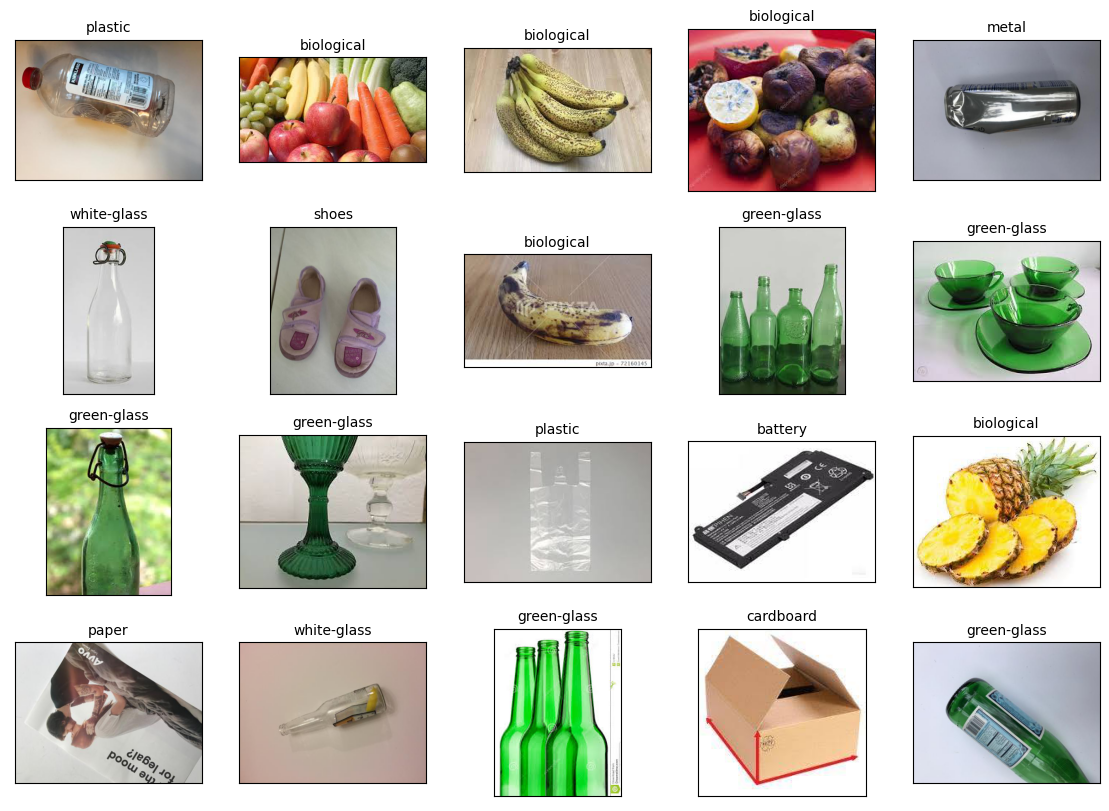

In [23]:

import matplotlib.pyplot as plt
import numpy as np
#Create a new matplotlib figure and make it 14 by 10 inches in size.
plt.figure(figsize=(14,10))
for i in range(20):
    #Find a random number which is inside of the dataset index.
    random = np.random.randint(1,len(df))
    #Create a subplot which is 4 by 5 and put the image in the i+1 position in the plot.
    plt.subplot(4,5,i+1)
    #Locate the image path within the dataframe using the random index we generated above.
    img = df.loc[random,"path"]
    #Use matplotlib to read and show the image. 
    plt.imshow(plt.imread(img))
    #Title the subplot by locating the label for the image in the dataframe using the same random index.
    plt.title(df.loc[random, "label"], size = 10, color = "black") 
    plt.xticks([])
    plt.yticks([])

#Show the plot of images.
plt.show()



In [25]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16
size=224
epoch=50
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='path',
    y_col='label',
    target_size=(size, size),
    batch_size=batch_size,
    class_mode="input"
    )
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='path',
    y_col='label',
    target_size=(size, size),
    batch_size=batch_size,
    class_mode="input"
    )

Found 5827 validated image filenames.
Found 1457 validated image filenames.


In [26]:
class AutoEncoder(keras.Model):
    def __init__(self, input_shape):
        super(AutoEncoder, self).__init__()
        self.encoder = self.build_encoder(input_shape)
        latent_dim = self.encoder.output_shape[1:]
        print(latent_dim)
        self.decoder = self.build_decoder(latent_dim)
    
    def se_block(self, inputs, units): # squeeze and excitation block
        inputs_channels = inputs.shape[-1]
        x = keras.layers.GlobalAveragePooling2D()(inputs)
        x = keras.layers.Dense(units, activation='relu')(x)
        x = keras.layers.Dense(inputs_channels, activation='sigmoid')(x)
        x = tf.reshape(x, [-1, 1, 1, inputs_channels])
        x = keras.layers.Multiply()([inputs, x])
        return x
    
    def build_encoder(self, input_shape):
        inputs = keras.Input(shape=input_shape)
        x = keras.layers.Conv2D(48, (3, 3), activation='relu', padding='same')(inputs)
        x = self.se_block(x, 20)
        x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
        x = keras.layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
        x = self.se_block(x, 30) 
        x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
        x = keras.layers.Conv2D(192, (3, 3), activation='relu', padding='same')(x)
        x = self.se_block(x, 50)
        x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
        encoded = keras.layers.Conv2D(32, (1, 1), activation='relu', padding='same')(x)
        return keras.Model(inputs, encoded, name='encoder')
    
    def build_decoder(self, latent_shape):
        inputs = keras.Input(shape=latent_shape)
        x = keras.layers.Conv2D(192, (1, 1), activation='relu', padding='same')(inputs)
        x = keras.layers.UpSampling2D((2, 2))(x)
        x = keras.layers.Conv2D(192, (3, 3), activation='relu', padding='same')(x)
        x = keras.layers.UpSampling2D((2, 2))(x)
        x = keras.layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
        x = keras.layers.UpSampling2D((2, 2))(x)
        x = keras.layers.Conv2D(48, (3, 3), activation='relu', padding='same')(x)
        decoded = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
        return keras.Model(inputs, decoded, name='decoder')
    
    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded


In [27]:
autoencoder = AutoEncoder((224, 224, 3))

(28, 28, 32)


In [28]:
autoencoder.compile(optimizer=tf.keras.optimizers.experimental.Adamax(), loss='binary_crossentropy')
history = autoencoder.fit(train_generator,validation_data=valid_generator, epochs=epoch, verbose=2)

Epoch 1/50
365/365 - 85s - loss: 0.4492 - val_loss: 0.4304 - 85s/epoch - 232ms/step
Epoch 2/50
365/365 - 45s - loss: 0.4172 - val_loss: 0.4113 - 45s/epoch - 124ms/step
Epoch 3/50
365/365 - 45s - loss: 0.4138 - val_loss: 0.4076 - 45s/epoch - 124ms/step
Epoch 4/50
365/365 - 45s - loss: 0.4111 - val_loss: 0.4126 - 45s/epoch - 123ms/step
Epoch 5/50
365/365 - 45s - loss: 0.4098 - val_loss: 0.4056 - 45s/epoch - 123ms/step
Epoch 6/50
365/365 - 45s - loss: 0.4096 - val_loss: 0.4050 - 45s/epoch - 123ms/step
Epoch 7/50
365/365 - 45s - loss: 0.4085 - val_loss: 0.4048 - 45s/epoch - 123ms/step
Epoch 8/50
365/365 - 45s - loss: 0.4078 - val_loss: 0.4037 - 45s/epoch - 124ms/step
Epoch 9/50
365/365 - 45s - loss: 0.4075 - val_loss: 0.4039 - 45s/epoch - 123ms/step
Epoch 10/50
365/365 - 45s - loss: 0.4066 - val_loss: 0.4034 - 45s/epoch - 124ms/step
Epoch 11/50
365/365 - 45s - loss: 0.4068 - val_loss: 0.4033 - 45s/epoch - 123ms/step
Epoch 12/50
365/365 - 45s - loss: 0.4062 - val_loss: 0.4025 - 45s/epoch - 

(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>)

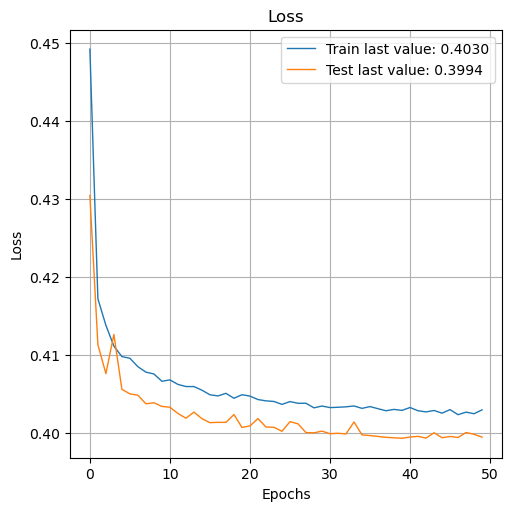

In [30]:
!pip install -q plot_keras_history
from plot_keras_history import plot_history
plot_history(history)

In [34]:
autoencoder.save_weights("autoencoder_weights.hdf5")

In [35]:
autoencoder.encoder.save("encoder.h5")

In [36]:
autoencoder.decoder.save("decoder.h5")

In [37]:
import cv2
import numpy as np
def plot_test(test_ds):
    img_num = np.random.randint(0, test_ds.shape[0]+1)
    
    orig = cv2.imread(test_ds.iloc[img_num]['path']) 
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    orig=orig* 1.0 / 255.0
    orig = cv2.resize(orig, (size, size),interpolation = cv2.INTER_NEAREST)
    img = tf.expand_dims(orig, axis=0)

    encoded_img = autoencoder.encoder.predict(img)
    recon_img = autoencoder.decoder.predict(encoded_img)
    
    plt.figure(figsize=(20,16))
    
    plt.subplot(1,3,1)
    plt.imshow(orig)
    plt.title('Original Image')
    
    plt.subplot(1,3,2)
    plt.imshow(encoded_img[0][0])
    plt.title('Encoded Representation')
    
    plt.subplot(1,3,3)
    plt.imshow(recon_img[0])
    plt.title('Reconstructed Image')
    
    plt.show()


1/1 [==============================] - 0s 18ms/step


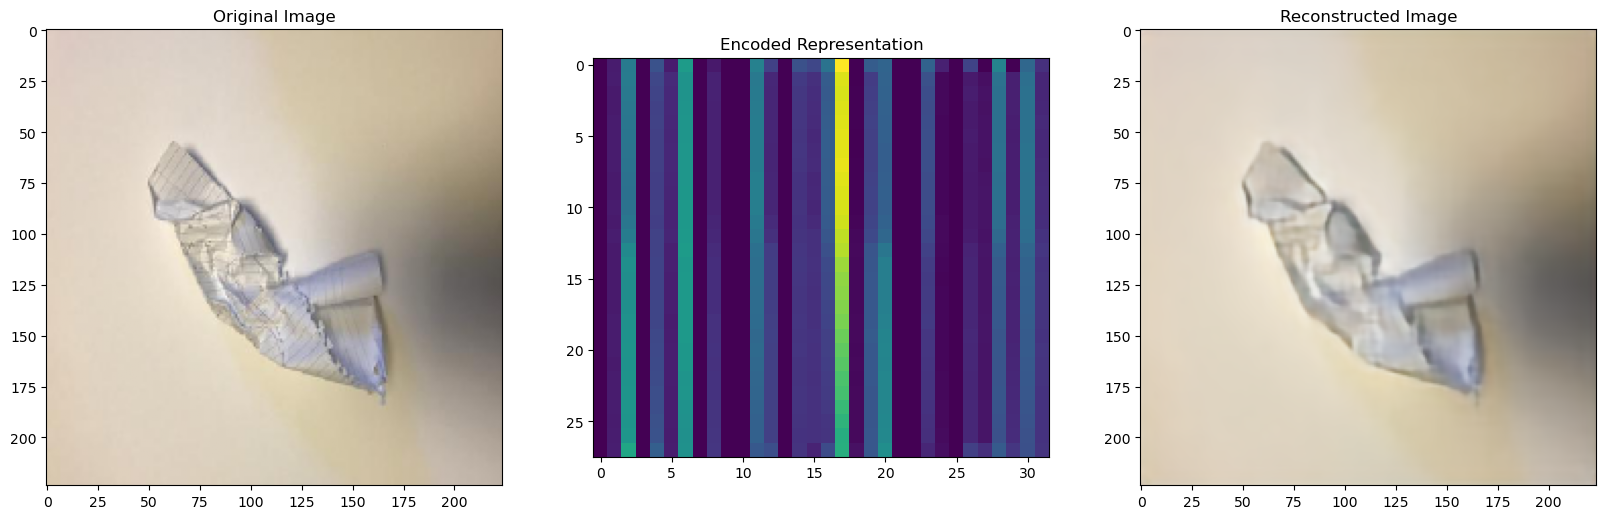

In [53]:
plot_test(test)

1/1 [==============================] - 0s 20ms/step


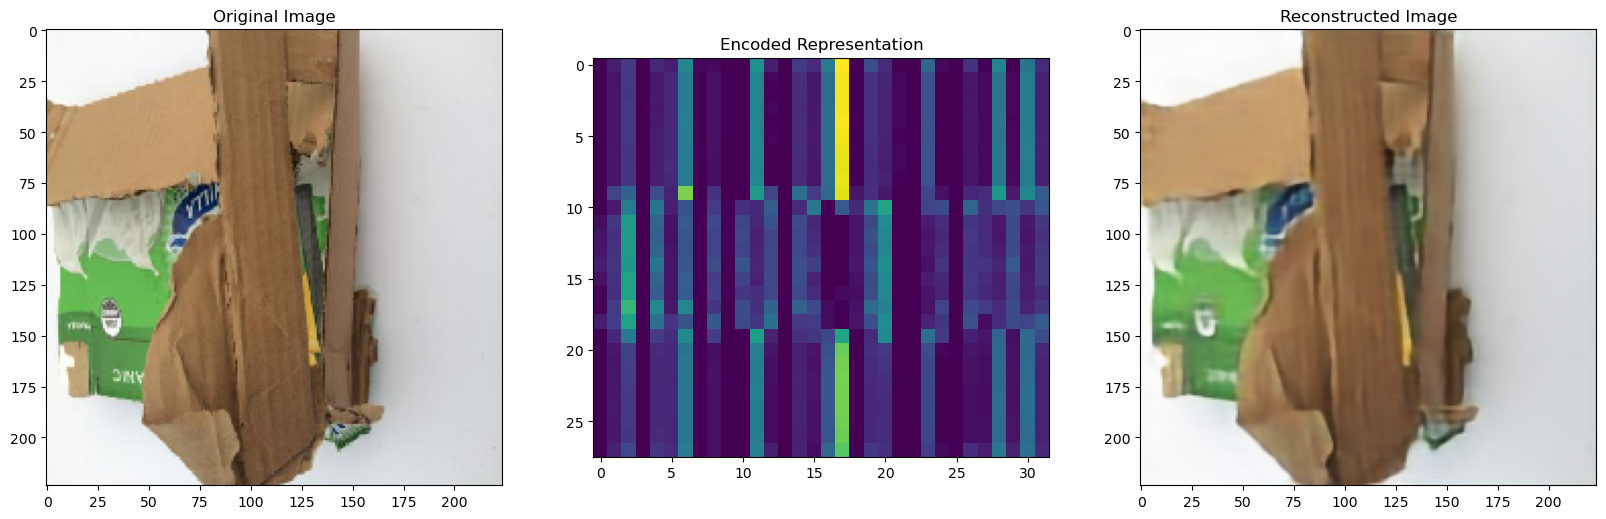

In [81]:
plot_test(test)

1/1 [==============================] - 0s 23ms/step


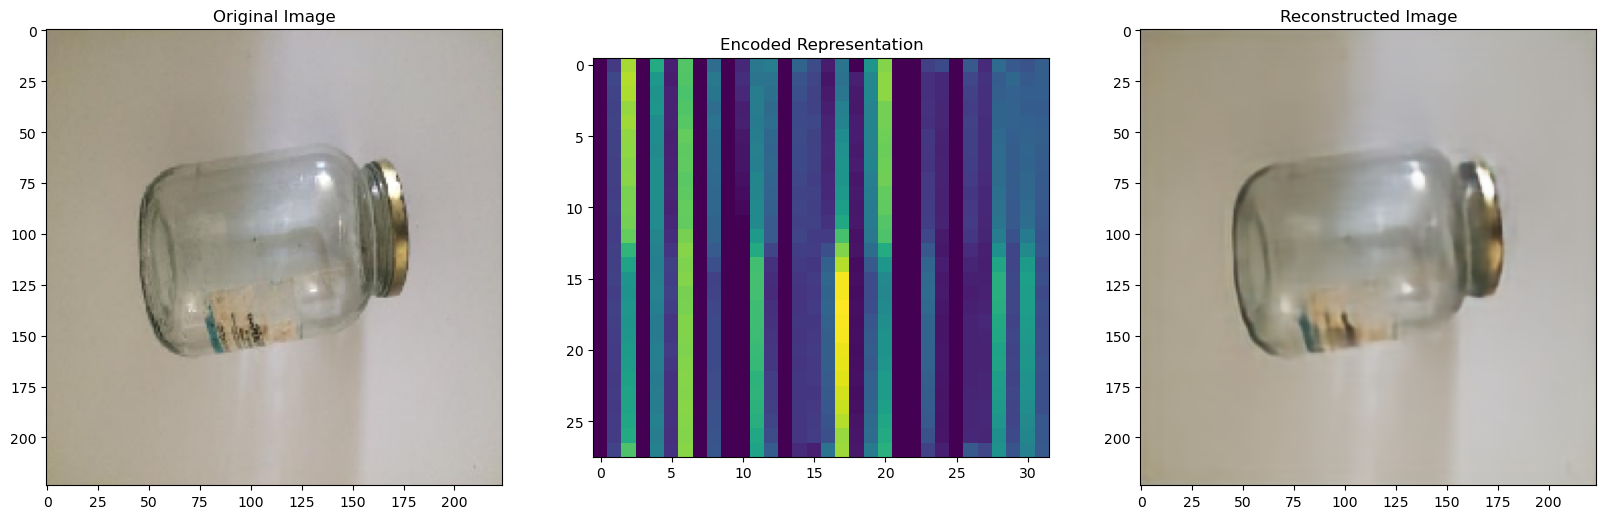

In [92]:
plot_test(test)

1/1 [==============================] - 0s 18ms/step


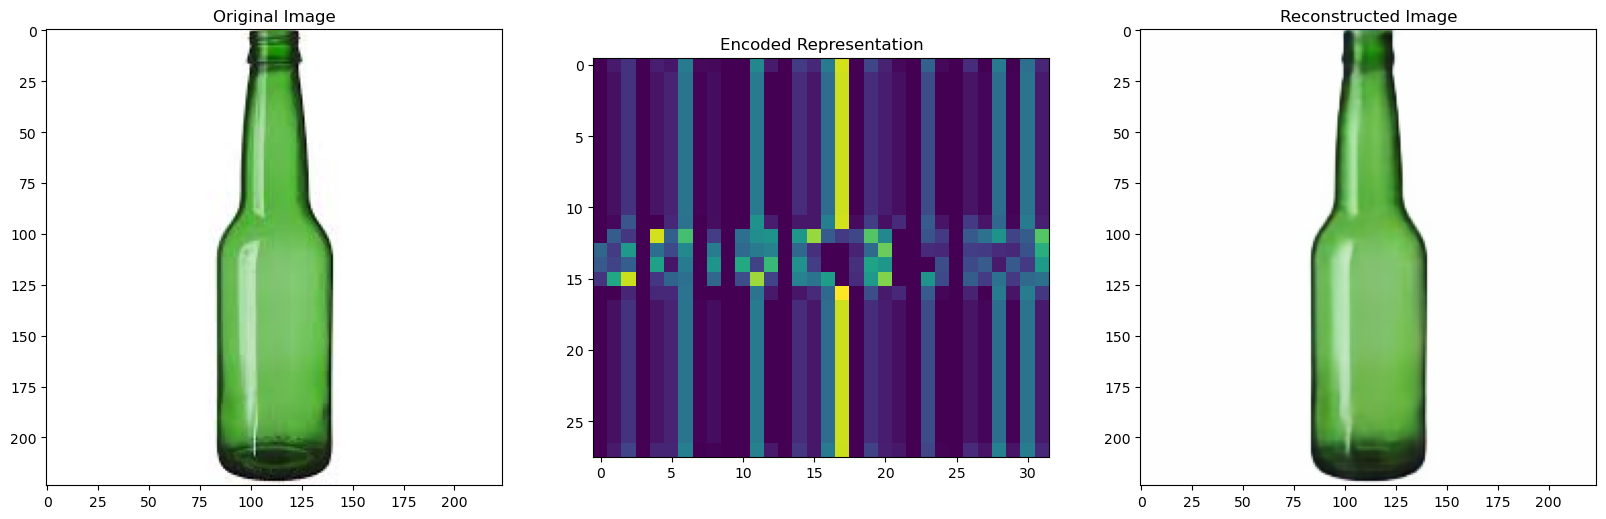

In [107]:
plot_test(test)

1/1 [==============================] - 0s 17ms/step


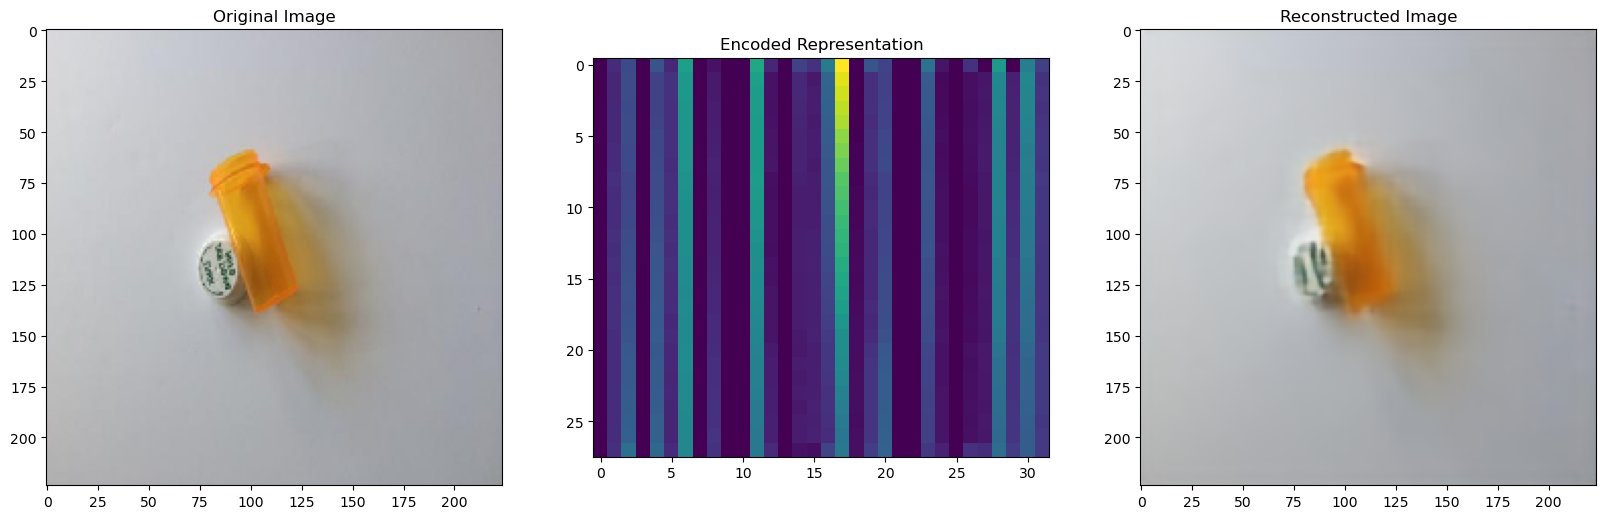

In [101]:
plot_test(test)